In [1]:
import torch
import torch.nn as nn
import mamba_ssm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange, tqdm

/gpfs/users/goon/.pyenv/versions/3.9.20/envs/mamba/lib/python3.9/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/gpfs/users/goon/.pyenv/versions/3.9.20/envs/mamba/lib/python3.9/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/gpfs/users/goon/.pyenv/versions/3.9.20/envs/mamba/lib/python3.9/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/gpfs/users/goon/.pyenv/versions/3.9.20/envs/mamba/lib/python3.9/site-packages/mamba_

In [21]:
in_features_min=64
in_features_max=8192
head_dim=64
seq_len=512
bsz=2
device="cuda"

In [22]:
in_feat = in_features_min
in_features_list = []
while in_feat <= in_features_max:
    in_features_list.append(in_feat)
    in_feat *= 2


In [23]:
def init_lins(mod: nn.Module)->None:
    for lin_name, lin in mod.named_modules():
        if isinstance(lin, nn.Linear):
            print(f"Init {lin_name=}")
            nn.init.normal_(lin.weight, std=1/(lin.in_features**0.5))
            if lin.bias is not None:
                nn.init.zeros_(lin.bias)


In [31]:
mlp = GatedMLP(512, device=device)
with torch.no_grad():
    print(mlp.fc1.weight.mean())
    print(mlp.fc1.weight.pow(2).mean())

mlp = GatedMLP(512, device=device)
init_lins(mlp)
with torch.no_grad():
    print(mlp.fc1.weight.mean())
    print(mlp.fc1.weight.pow(2).mean())

tensor(-2.6043e-06, device='cuda:0')
tensor(0.0007, device='cuda:0')
Init lin_name='fc1'
Init lin_name='fc2'
tensor(-2.5278e-05, device='cuda:0')
tensor(0.0020, device='cuda:0')


In [39]:
inputs = torch.randn(16, 512, device=device)
lin = nn.Linear(512, 512, bias=False, device=device)
with torch.no_grad():
    out = lin(inputs)
    print(out.mean())
    print(out.pow(2).mean())
    
lin = nn.Linear(512, 512, bias=False, device=device)
init_lins(lin)
with torch.no_grad():
    out = lin(inputs)
    print(out.mean())
    print(out.pow(2).mean())

tensor(-0.0006, device='cuda:0')
tensor(0.3244, device='cuda:0')
Init lin_name=''
tensor(0.0114, device='cuda:0')
tensor(0.9858, device='cuda:0')


In [40]:
from mamba_ssm.modules.mlp import GatedMLP
    
mlp_amp = False
mlp_results = []
for custom_init in (True, False):
    for in_features in tqdm(in_features_list): 
        mlp = GatedMLP(in_features, device=device)
        if custom_init:
            init_lins(mlp)
        
        inputs = torch.randn(bsz, seq_len, in_features, device=device)
        with torch.no_grad():
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=mlp_amp):
                outputs = mlp(inputs)
        mlp_results_dict = {"in_features": in_features,
                        "l2_mean": outputs.pow(2).mean().item(),
                        "l1_mean": outputs.abs().mean().item(),
                        "l2_sum": outputs.pow(2).sum().item(),
                        "l1_sum": outputs.abs().sum().item(),
                        "std": outputs.std().item(),
                        "var": outputs.var().item(),
                        "mean": outputs.mean().item(),
                        "custom_init": custom_init,
                       }
        mlp_results.append(mlp_results_dict)
    
mlp_df = pd.DataFrame(mlp_results)
mlp_df

  0%|          | 0/8 [00:00<?, ?it/s]

Init lin_name='fc1'
Init lin_name='fc2'
Init lin_name='fc1'
Init lin_name='fc2'
Init lin_name='fc1'
Init lin_name='fc2'
Init lin_name='fc1'
Init lin_name='fc2'
Init lin_name='fc1'
Init lin_name='fc2'
Init lin_name='fc1'
Init lin_name='fc2'
Init lin_name='fc1'
Init lin_name='fc2'
Init lin_name='fc1'
Init lin_name='fc2'


  0%|          | 0/8 [00:00<?, ?it/s]

,in_features,l2_mean,l1_mean,l2_sum,l1_sum,std,var,mean,custom_init
0,64,0.366753,0.470395,2.403551e+04,3.082781e+04,0.605586,0.366734,-0.004956,True
1,128,0.354684,0.467672,4.648920e+04,6.129871e+04,0.595546,0.354675,0.003544,True
2,256,0.365243,0.478146,9.574615e+04,1.253430e+05,0.604354,0.365244,-0.000163,True
3,512,0.356025,0.474430,1.866596e+05,2.487381e+05,0.596679,0.356026,0.000231,True
4,1024,0.356571,0.475433,3.738913e+05,4.985273e+05,0.597135,0.356570,0.000803,True
5,2048,0.357478,0.476490,7.496852e+05,9.992725e+05,0.597895,0.357478,0.000323,True
6,4096,0.355819,0.475812,1.492412e+06,1.995701e+06,0.596506,0.355819,0.000050,True
7,8192,0.355728,0.475738,2.984065e+06,3.990780e+06,0.596430,0.355728,0.000145,True
8,64,0.011802,0.084735,7.734446e+02,5.553188e+03,0.108634,0.011801,-0.000747,False
9,128,0.011297,0.083749,1.480745e+03,1.097709e+04,0.106286,0.011297,-0.000756,False


Text(0.5, 0.98, 'MLP scaling')

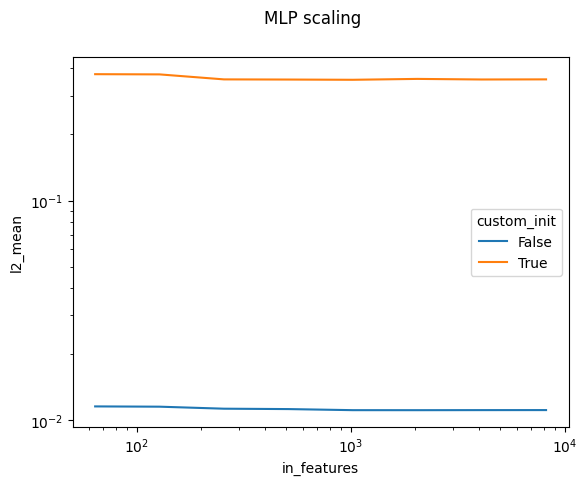

In [17]:
mlp_plot = sns.lineplot(data=mlp_df, x="in_features", y="l2_mean", hue="custom_init")
mlp_plot.set(xscale="log")
mlp_plot.set(yscale="log")
plt.suptitle("MLP scaling")

In [18]:
from mamba_ssm.modules.mha import MHA

attn_results = []
attn_amp = False
for custom_init in (True, False):
    for in_features in tqdm(in_features_list):
        attn_cfg = {
        "causal": True,
        "head_dim": head_dim,
        "num_heads": in_features // head_dim,
        "out_proj_bias": False,
        "qkv_proj_bias": False,
        "rotary_emb_dim": head_dim // 2,  # Apparently correct for mamba-ssm
    }
    
        mha = MHA(in_features, **attn_cfg, device=device)
        if custom_init:
            init_lins(mha)
        inputs = torch.randn(bsz, seq_len, in_features, device=device)
        with torch.no_grad():
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=attn_amp):
                outputs = mha(inputs)
        attn_results_dict = {"in_features": in_features,
                        "l2_mean": outputs.pow(2).mean().item(),
                        "l1_mean": outputs.abs().mean().item(),
                        "l2_sum": outputs.pow(2).sum().item(),
                        "l1_sum": outputs.abs().sum().item(),
                        "std": outputs.std().item(),
                        "var": outputs.var().item(),
                        "mean": outputs.mean().item(),
                        "custom_init": custom_init,
                       }
        attn_results.append(attn_results_dict)

attn_df = pd.DataFrame(attn_results)
attn_df


  0%|          | 0/8 [00:00<?, ?it/s]

Init lin_name='in_proj'
Init lin_name='out_proj'
Init lin_name='in_proj'
Init lin_name='out_proj'
Init lin_name='in_proj'
Init lin_name='out_proj'
Init lin_name='in_proj'
Init lin_name='out_proj'
Init lin_name='in_proj'
Init lin_name='out_proj'
Init lin_name='in_proj'
Init lin_name='out_proj'
Init lin_name='in_proj'
Init lin_name='out_proj'
Init lin_name='in_proj'
Init lin_name='out_proj'


  0%|          | 0/8 [00:00<?, ?it/s]

,in_features,l2_mean,l1_mean,l2_sum,l1_sum,std,var,mean,custom_init
0,64,0.040736,0.139747,2669.693359,9158.465820,0.201623,0.040652,0.009224,True
1,128,0.032873,0.123248,4308.675781,16154.333984,0.181308,0.032873,-0.000370,True
2,256,0.029835,0.116878,7821.151367,30638.953125,0.172694,0.029823,0.003473,True
3,512,0.029060,0.113484,15235.564453,59498.351562,0.170468,0.029059,0.000367,True
4,1024,0.027290,0.109145,28615.222656,114446.718750,0.165195,0.027290,0.000297,True
5,2048,0.026340,0.106616,55239.871094,223589.562500,0.162295,0.026340,0.000885,True
6,4096,0.027400,0.107893,114924.906250,452537.531250,0.165529,0.027400,-0.000729,True
7,8192,0.026766,0.107003,224531.781250,897608.875000,0.163604,0.026766,-0.000403,True
8,64,0.001578,0.024109,103.427834,1580.004883,0.039703,0.001576,-0.001360,False
9,128,0.001618,0.024052,212.016891,3152.544434,0.040174,0.001614,-0.001895,False


In [ ]:
attn_plot = sns.lineplot(data=attn_df, x="in_features", y="l2_mean", hue="custom_init")
attn_plot.set(xscale="log")
attn_plot.set(yscale="log")

plt.suptitle("MHA scaling")

Text(0.5, 0.98, 'MHA scaling')

In [20]:
import torch.nn as nn
from typing import Any, Optional

class InputStatsHook:
    def __init__(
        self,
        module: nn.Module,
        name: str,
        results_list: list[dict],
        width: int,
        other_data: Optional[dict] = None,
    ) -> None:
        self.module = module
        self.name = name
        self.width = width
        self.results_list = results_list
        self._hook = module.register_forward_pre_hook(self)
        self._step = 0
        self.other_data = other_data or {}

    def __call__(self, module: nn.Module, args: Any) -> None:
        inputs = args[0]
        results = {"name": self.name, "width": self.width, "step": self._step}
        results = {**results, **self.other_data}
        with torch.no_grad():
            results["mean"] = inputs.mean().item()
            results["l1_mean"] = inputs.abs().mean().item()
            results["l2_mean"] = inputs.pow(2).mean().item()
            results["std"] = inputs.std().item()
            results["var"] = inputs.var().item()
        self.results_list.append(results)
        self._step += 1



    def remove(self) -> None:
        self._hook.remove()


In [ ]:
from mamba_ssm.models.config_mamba import MambaConfig
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from fms_fsdp.mup.mup_mamba import apply_mup_init


model_results = []
lm_head_input_results = []
model_amp = True
mup = True
n_layer=4
vocab_size=128256
head_dim=128
for in_features in trange(in_features_min, in_features_max+1, 4*head_dim):
    attn_cfg = {
    "causal": True,
    "head_dim": head_dim,
    "num_heads": in_features // head_dim,
    "out_proj_bias": False,
    "qkv_proj_bias": False,
    "rotary_emb_dim": head_dim // 2,  # Apparently correct for mamba-ssm
}
    if mup:
        attn_cfg["softmax_scale"] = head_dim
    
    config = MambaConfig(
    d_model=in_features,
    d_intermediate=4 * in_features,
    n_layer=n_layer,
    attn_layer_idx=list(range(n_layer)),  # Transformer-only blocks
    vocab_size=vocab_size,
    attn_cfg=attn_cfg,
    tie_embeddings=False,
)
    model = MambaLMHeadModel(config=config, device=device)

    hook = InputStatsHook(model.lm_head, "lm_head", lm_head_input_results, width=in_features)
    if mup:
        apply_mup_init(model)
    inputs = torch.randint(vocab_size, size=(bsz, seq_len), device=device)
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=model_amp):
            outputs = model(inputs).logits
        print(f"{outputs.shape=}, {in_features=}")
    model_results_dict = {"in_features": in_features,
                    "l2_mean": outputs.pow(2).mean().item(),
                    "l1_mean": outputs.abs().mean().item(),
                    "l2_sum": outputs.pow(2).sum().item(),
                    "l1_sum": outputs.abs().sum().item(),
                    "std": outputs.std().item(),
                    "var": outputs.var().item(),
                    "mean": outputs.mean().item(),
                   }
    model_results.append(model_results_dict)
model_df = pd.DataFrame(model_results)
model_df


In [ ]:
model_plot = sns.lineplot(data=model_df, x="in_features", y="l2_mean")
model_plot.set(xscale="log")
model_plot.set(yscale="log")

plt.suptitle("Model scaling")


In [ ]:
lm_head_df = pd.DataFrame(lm_head_input_results)
lm_head_df


In [ ]:
lm_head_plot = sns.lineplot(data=lm_head_df, x="width", y="l2_mean")
lm_head_plot.set(xscale="log")
lm_head_plot.set(yscale="log")

plt.suptitle("LM Head scaling")

In [ ]:
lm_head_df

In [47]:
test_data = [{"x": y, "y":y + 1 if group == "red" else 0, "group": group} for group in ("red", "blue") for y in range(10)]

In [48]:
test_df = pd.DataFrame(test_data)
test_df

,x,y,group
0,0,1,red
1,1,2,red
2,2,3,red
3,3,4,red
4,4,5,red
5,5,6,red
6,6,7,red
7,7,8,red
8,8,9,red
9,9,10,red


<Axes: xlabel='x', ylabel='y'>

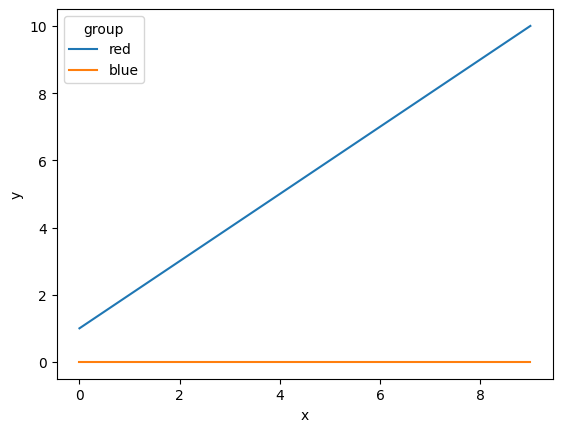

In [50]:
sns.lineplot(data=test_df, x="x", y="y", hue="group")

In [98]:
dd = {g: (1, 0) for g in test_df.group.unique()}
dd["blue"] = (4, 2)

<Axes: xlabel='x', ylabel='y'>

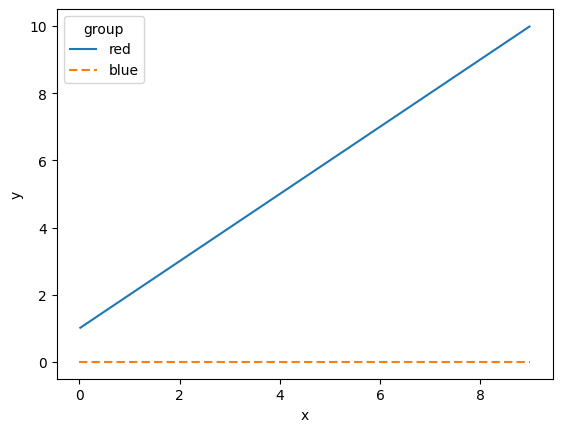

In [99]:
sns.lineplot(data=test_df, x="x", y="y", hue="group", dashes=dd, style="group")